# Introduction
This tutorial reproduces [Thomas et al](https://arxiv.org/abs/2004.14256), titled **Efficient cavity control with SNAP gates**. Here the aim is to apply a seqeunce of Displace operators and SNAP gates, called blocks, $\hat{B}$ on an initial 10-dimensional vacuum state, $|0>$ with just the right parameters such that with the action of three such blocks, $\hat{B}$ we land on to the target binomial state $b_{1}$

In [1]:
from qgrad.qgrad_qutip import basis, to_dm, dag, Displace, fidelity
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt

from qutip.visualization import plot_wigner, hinton
from qutip import Qobj # imported purely for visualization purposes due to QuTiP-JAX non-compatibility
import numpy as onp

In [2]:
def pad_thetas(hilbert_size, thetas):
    """
    Helper function to pad zeros to the end of a theta vector to fill it upto the Hilbert space cuttoff.
    
    Args:
    -----
        hilbert_size (int): Size of the hilbert space
        thetas (:obj:`jnp.ndarray`): List of angles thetas
    
    Returns:
    --------
        thetas (:obj:`jnp.ndarray`): List of angles padded with zeros in place of Hilbert space cutoff

    """
    if len(thetas) != hilbert_size:
        thetas = jnp.pad(thetas, (0, hilbert_size - len(thetas)), mode="constant")
    return thetas

def snap(hilbert_size, thetas):
    """
    SNAP gate matrix.
    
    Args:
    -----
        hilbert_size (int): Hilbert space cuttoff
        thetas (:obj:`jnp.ndarray`): A vector of theta values to apply SNAP operation
    
    Returns:
    --------
        op (:obj:`jnp.ndarray`): matrix representing the SNAP gate
    """
    op = 0 * jnp.eye(hilbert_size)
    for i, theta in enumerate(thetas):
        op += jnp.exp(1j * theta) * to_dm(basis(hilbert_size, i))
    return op

# Insertion of Blocks

The authors add $T$ blocks on the initial vacuum state, where each block, $\hat B$ takes the following form

\begin{equation}
\hat B = D(\alpha) \hat S(\vec \theta) D(\alpha)^{\dagger}
\end{equation}

Here $D(\alpha)$ is the displacement operator (that comes with qgrad) with displacement $\alpha$ 
and $\hat S(\vec \theta)$ is the SNAP gate with parameter vector $\vec(\theta)$ of length $N$, the size of the Hilbert space.
         


In [3]:
def add_blocks(initial, T, hilbert_size, params):
    """
    Applies T blocks of operators to the initial state.
    
    Args:
    ------
        initial (jnp.ndarray): initial state to apply blocks on (ket |0> in our case)
        T (int): number of blocks to apply
        hilbert_size (int): Size of the Hilbert space
        params (jnp.ndarray): parameter array of alphas and thethas of size :math: `T * hilbert_size + T`, 
                wherein the first T parameters are alphas and the rest are T hilbert_size-dimensional vectors 
                representing corresponding theta vectors.

    Returns:
    -----------
         evolved (jnp.array): (hilbert_size, 1) dimensional array representing the action of the T
                  blocks on the vacuum state
    """
    displace = Displace(N)
    for t in range(T):
        blk = jnp.dot(displace(params[0 + t]), initial)
        blk = jnp.dot(snap(hilbert_size, params[T + (t * hilbert_size) : T + (t + 1) * hilbert_size]), blk)
        initial = jnp.dot(displace(-params[0 + t]), blk) # displace(alpha)^{\dagger} = displace(-alpha)

    evolved = initial
    return evolved

In [4]:
def cost(params, initial, target, T, hilbert_size):
    """
    Calculates the cost between the target state and 
    the one evolved by the action of three blocks.
    
    Args:
    -----
        params (jnp.array): alpha and theta params of Displace and SNAP respectively
        initial (jnp.array): initial state to apply the blocks on
        target (jnp.array): desired state
    
    Returns:
    --------
        cost (float): cost at a particular parameter vector
    """
    evo = add_blocks(initial, T, hilbert_size, params)
    return 1 - fidelity(target, evo)[0][0]

# Initialize parameters

We start with an alomst alternating sequence of $\alpha$ and $\theta$ parameters as a gopod starting starting point, rather than random guessing. The target state is a binomial state

\begin{equation}
b_{1} = \frac{\sqrt 3 |3\rangle + |9\rangle}{2}
\end{equation}

In [5]:
T = 3 # Number of blocks, B, to apply
N = 10 # dimension of Fock space

alphas = jnp.array([1., 0.5, 1.]) # Displace parameters
theta1, theta2, theta3 = [0.5], [0.5, 1.5, 0.5], [0.5, 1.5, 0.5, 1.3] # SNAP parameters
# NOTE: No input values to JAX differentiable functions should be int

theta1, theta2, theta3 = pad_thetas(N, theta1), pad_thetas(N, theta2), pad_thetas(N, theta3)

initial = basis(N, 0) # initial vacuum state
target = (jnp.sqrt(3) * basis(10, 3) +  basis(10, 9)) / 2.0 # target state b1 as shown above|


/home/asad/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Gradient Descent -- Case in point for `qgrad`

This is where the power of `qgrad` comes in. Since qgrad's functions used in this notebook -- basis, to_dm, dag, Displace, fidelity -- support JAX, we can evaluate the gradient of the cost function in one line using JAX's `grad`. This saves us painstakingly evaluating the derivative of the cost function analytically.


In [6]:
epochs = 17
lr = 0.1 # learning rate
max_iters = 100
iters = 0
params = jnp.concatenate((alphas, theta1, theta2, theta3)).reshape(3 * N + 3, 1)
der_cost = grad(cost) # autodiff of the cost function

params_hist = [params]

for epoch in range (epochs):
    iters = 0
    while iters  < max_iters:
        prev_params = params
        der = der_cost(prev_params, initial, target, T, N)
        params = prev_params - lr * der 
        iters += 1
    cost_val = cost(params, initial, target, T, N)
    progress = [epoch+1, cost_val]
    if ((epoch + 2) % 2 != 0):
        params_hist.append(params)
        print("Epoch: {:2f} | Cost: {:3f}".format(*jnp.asarray(progress)))

Epoch: 2.000000 | Cost: 0.430335
Epoch: 4.000000 | Cost: 0.290234
Epoch: 6.000000 | Cost: 0.218124
Epoch: 8.000000 | Cost: 0.179733
Epoch: 10.000000 | Cost: 0.116785
Epoch: 12.000000 | Cost: 0.055570
Epoch: 14.000000 | Cost: 0.064104
Epoch: 16.000000 | Cost: 0.049646


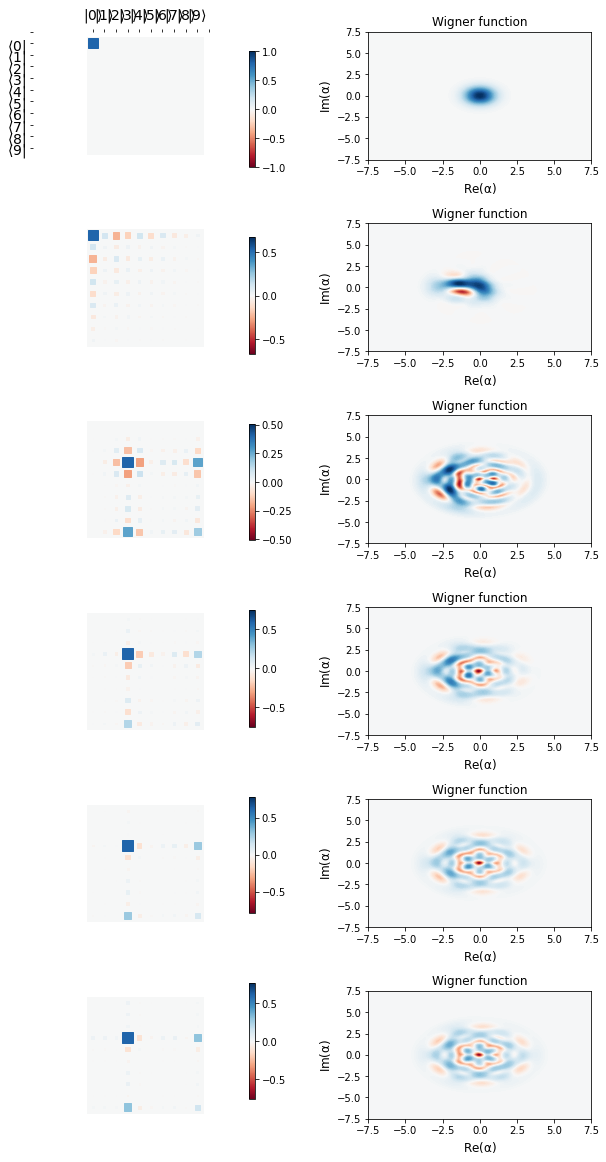

In [13]:
def display_evolution(parameters):
    """
    Displays the Wigner function of a state during the learning schedule
    """
    fig, ax = plt.subplots(6, 2, figsize=(10, 20))
    vacuum = onp.array(jnp.dot(initial, dag(initial)))
    hinton(Qobj(vacuum), ax=ax[0][0])
    plot_wigner(Qobj(vacuum), ax=ax[0][1])
    for i in range(4):
        pred = add_blocks(initial, T, N, parameters[2 * i])
        dm = jnp.dot(pred, dag(pred)) # This converting back and
        dm = onp.array(dm)            # forth between np and jnp is why we need qgrad
        hinton(dm, ax = ax[i+1][0])
        plot_wigner(Qobj(dm), ax=ax[i+1][1])
    
    # final parameters after 17th epoch
    pred =  add_blocks(initial, T, N, params)
    dm = onp.array(jnp.dot(pred, dag(pred))) 
    hinton(dm, ax = ax[5][0])
    plot_wigner(Qobj(dm), ax=ax[5][1])
    
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.show()
    
display_evolution(params_hist)

# Comments on Learning
We see that starting from a vacuum state $|0>$, we efficiently learn the target state
$b_{1} = \frac{\sqrt3 |3> + |9>}{2}$. The desired target state's Hinton plot and Wigner function are shown below. It can be seen that the last row above is almost the same as the target state shown below, implying we learn parameters $\alpha$ and $\vec \theta$ efficiently so as to go from the vacuum state to a desired target state (in this case a binomial state) in just three applications of blocks, $\hat B$. This tutorial is just meant to show the usage of `qgrad`. One may increase the number of epochs to achieve even better learning.

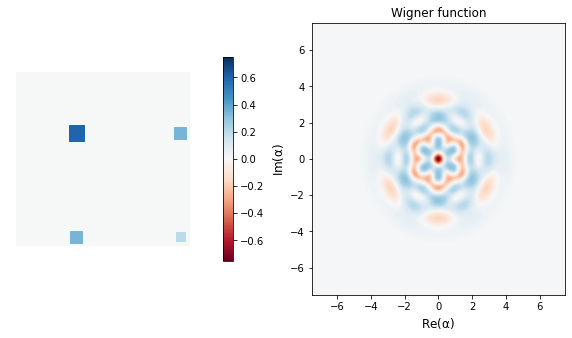

In [15]:
def display_ket(ket):
    """
    Shows the hinton plot and Wigner function of a ket
    """
    dm = jnp.dot(ket, dag(ket))
    dm = onp.array(dm)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    hinton(dm, ax=ax[0])
    plot_wigner(Qobj(dm), ax=ax[1])
    plt.show()

ket = basis(N, 5)
display_ket(target)